# Clustering Case Study: Customer Segmentation with K-Means -  Tier 3
***
This case study is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by the `yhat` blog. Please feel free to refer to the post for additional information, and solutions.

Structure of the mini-project:

1. **Sourcing and loading**
    * Load the data
    * Explore the data


2. **Cleaning, transforming and visualizing**
    * Data Wrangling: Exercise Set 1
        - Creating a matrix with a binary indicator for whether they responded to a given offer
        - Ensure that in doing so, NAN values are dealt with appropriately
    

3. **Modelling** 
    * K-Means clustering: Exercise Sets 2 and 3
        - Choosing K: The Elbow method
        - Choosing K: The Silhouette method
        - Choosing K: The Gap statistic method
    
    * Visualizing clusters with PCA: Exercise Sets 4 and 5


4. **Conclusions and next steps**
    * Conclusions
    * Other clustering algorithms (Exercise Set 6)

In [1]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

In [2]:
import warnings

# Customize how warnings are displayed
warnings.filterwarnings('always', module='.*')
warnings.formatwarning = lambda message, category, filename, lineno, line=None: f'{category.__name__}: {message}\n'

## 1. Sourcing and loading
### 1a. Load the data
The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [3]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheet_name=0)

### 1b. Explore the data

In [4]:
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [5]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## 2. Cleaning, transforming and visualizing
### 2a. Data Wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [6]:
#your turn
df_offers_transactions=pd.merge(df_offers,df_transactions,on='offer_id',how='outer')
df_offers_transactions

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak,customer_name,n
0,1,January,Malbec,72,56,France,False,Thomas,1
1,1,January,Malbec,72,56,France,False,Jackson,1
2,1,January,Malbec,72,56,France,False,Mitchell,1
3,1,January,Malbec,72,56,France,False,Peterson,1
4,1,January,Malbec,72,56,France,False,Wood,1
...,...,...,...,...,...,...,...,...,...
319,31,December,Champagne,72,89,France,False,Fisher,1
320,32,December,Cabernet Sauvignon,72,45,Germany,True,Young,1
321,32,December,Cabernet Sauvignon,72,45,Germany,True,Cooper,1
322,32,December,Cabernet Sauvignon,72,45,Germany,True,Gomez,1


In [7]:
df_transactions_pivot=pd.pivot_table(df_offers_transactions.dropna(),index='customer_name',columns='offer_id',values='n',aggfunc='sum',fill_value=0).reset_index()
df_transactions_pivot

offer_id,customer_name,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,Adams,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
1,Allen,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2,Anderson,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
3,Bailey,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,Baker,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Williams,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
96,Wilson,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
97,Wood,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
98,Wright,0,0,0,1,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0


<Axes: xlabel='offer_id', ylabel='customer_name'>

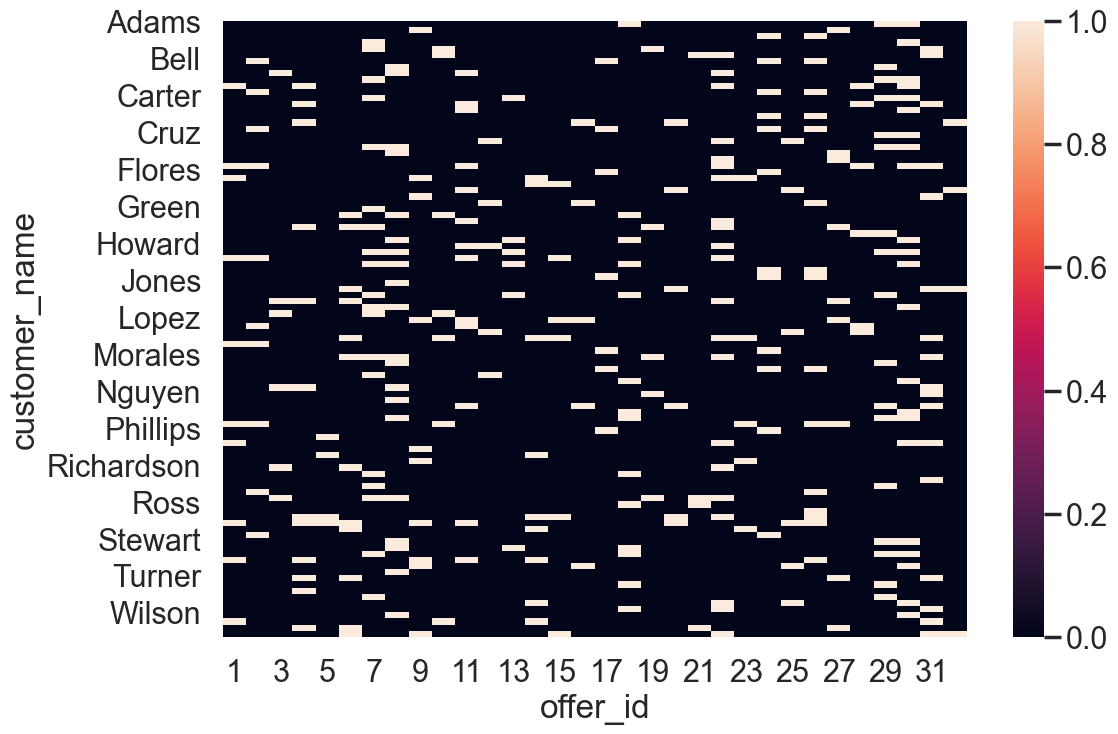

In [8]:
# Plot the points on X,Y
fig,axs=plt.subplots(1,1,figsize=(12,8))
sns.heatmap(data=df_transactions_pivot.set_index('customer_name'))

## 3. Modelling 
### 3a. K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

#### 3ai. Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

**Hint:** the Elbow Method is discussed in part 2 of the Harvard Clustering lecture. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

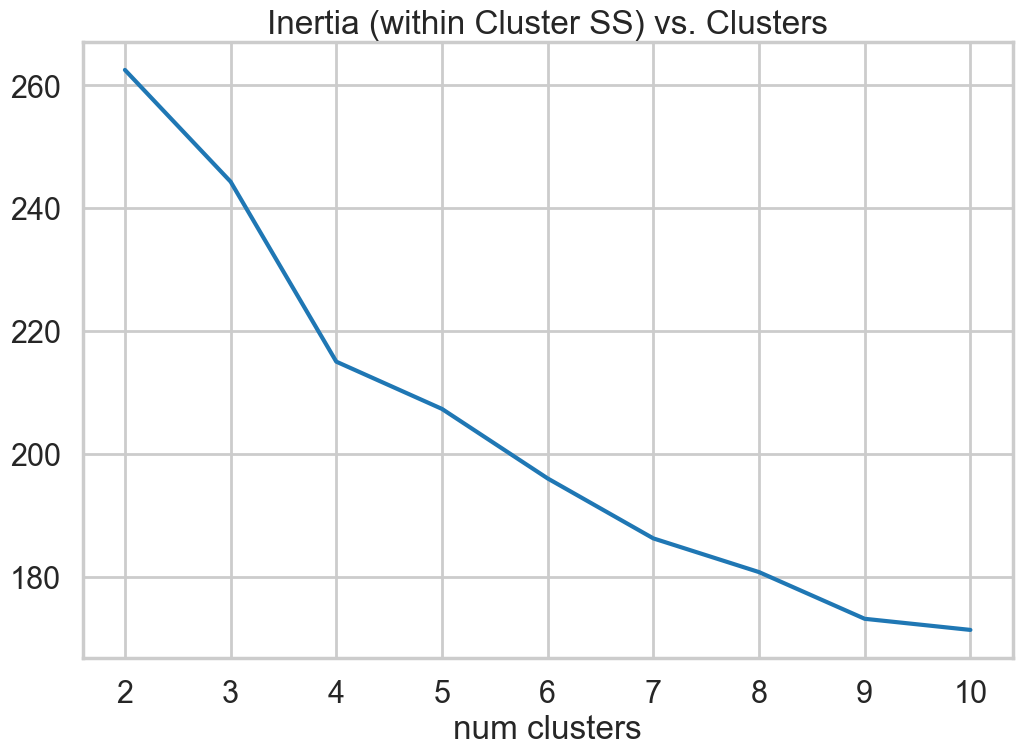

In [9]:
# your turn
import numpy as np
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.model_selection import ParameterGrid

x_cols=np.array([col for col in df_transactions_pivot.columns if type(col)==int])
score={}
# Define a parameter grid
param_grid = {
    'n_clusters': range(2,11)
}

# Generate all combinations of parameters
grid = ParameterGrid(param_grid)

# Iterate over the parameter grid
for i,params in enumerate(grid):
    #print(params);
    model=KMeans(n_clusters=params['n_clusters'])
    model.fit(df_transactions_pivot[x_cols])
    score[i+2]=model.inertia_

fig,axs=plt.subplots(1,1,figsize=(12,8))
sns.lineplot(score)
axs.set_xlabel('num clusters')
plt.title('Inertia (within Cluster SS) vs. Clusters')
plt.show()


<b> Within this range of num clusters there is no clear knee to help us determine what the best value of K should be

#### 3aii. Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

**Hint**: Scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

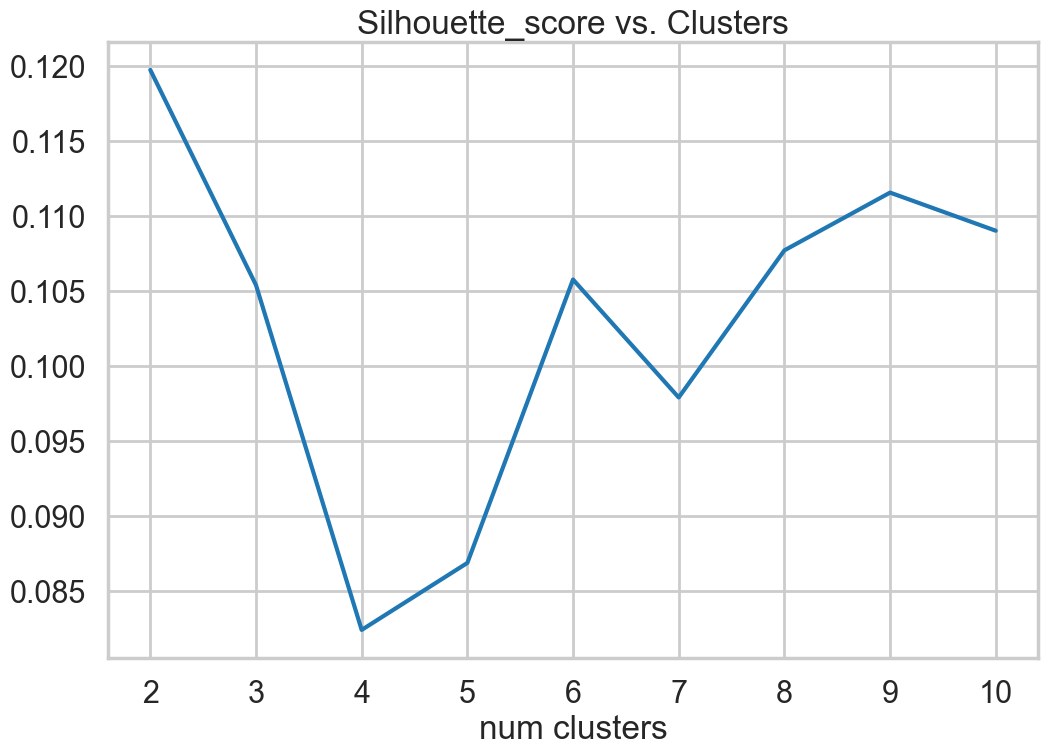

In [10]:
# Your turn.
from sklearn.metrics import silhouette_score
score={}
# Define a parameter grid
param_grid = {
    'n_clusters': range(2,11)
}

# Generate all combinations of parameters
grid = ParameterGrid(param_grid)

# Iterate over the parameter grid
for i,params in enumerate(grid):
    #print(params);
    model=KMeans(n_clusters=params['n_clusters'])
    X=df_transactions_pivot[x_cols]
    score[i+2]=silhouette_score(X,model.fit_predict(X))

fig,axs=plt.subplots(1,1,figsize=(12,8))
sns.lineplot(score)
axs.set_xlabel('num clusters')
plt.title('Silhouette_score vs. Clusters')
plt.show()

<b> Clustering is weak and almost random (due to high entropy in data)

<Axes: xlabel='offer_id', ylabel='customer_name'>

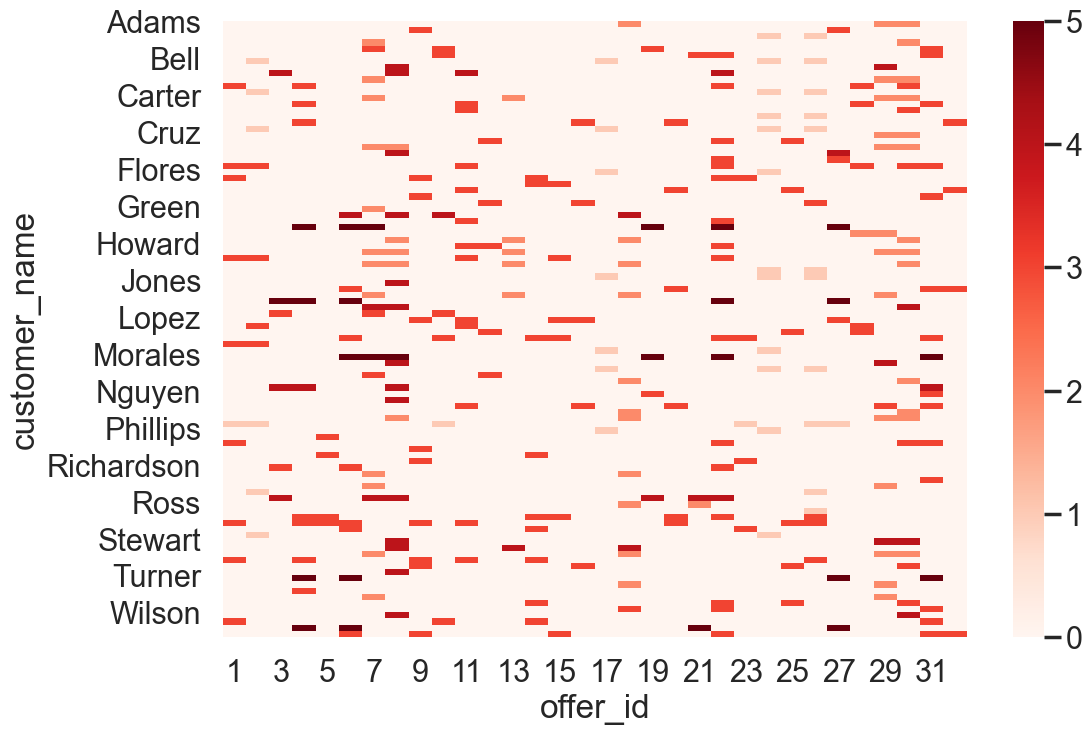

In [11]:
# Create cluster labels with n_clusters=5
model=KMeans(n_clusters=5)
labels=model.fit_predict(df_transactions_pivot[x_cols])
# Plot the points on X,Y
df_transactions_pivot['label']=labels+1

X=df_transactions_pivot.set_index('customer_name')
X[x_cols]=X[x_cols].values*X['label'].values.reshape(-1,1)
X=X.drop(columns='label')

fig,axs=plt.subplots(1,1,figsize=(12,8))
sns.heatmap(data=X,cmap='Reds')

<b> When n_clusters=5 it is difficult to spatially distinguish them as they are spread out

How do the clusters tie into the other wine parameters?

In [12]:
df_offers_transactions_labels=pd.merge(df_offers_transactions,df_transactions_pivot[['customer_name','label']],on='customer_name',how='right').rename(
    columns={'label':'Customer_Offer_Cluster_Label'})
df_offers_transactions_labels

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak,customer_name,n,Customer_Offer_Cluster_Label
0,18,July,Espumante,6,50,Oregon,False,Adams,1,2
1,29,November,Pinot Grigio,6,87,France,False,Adams,1,2
2,30,December,Malbec,6,54,France,False,Adams,1,2
3,9,April,Chardonnay,144,57,Chile,False,Allen,1,3
4,27,October,Champagne,72,88,New Zealand,False,Allen,1,3
...,...,...,...,...,...,...,...,...,...,...
319,9,April,Chardonnay,144,57,Chile,False,Young,1,3
320,15,June,Cabernet Sauvignon,144,19,Italy,False,Young,1,3
321,22,August,Champagne,72,63,France,False,Young,1,3
322,31,December,Champagne,72,89,France,False,Young,1,3


Text(0.5, 1.0, 'Plot showing Customer tastes for Wine Type')

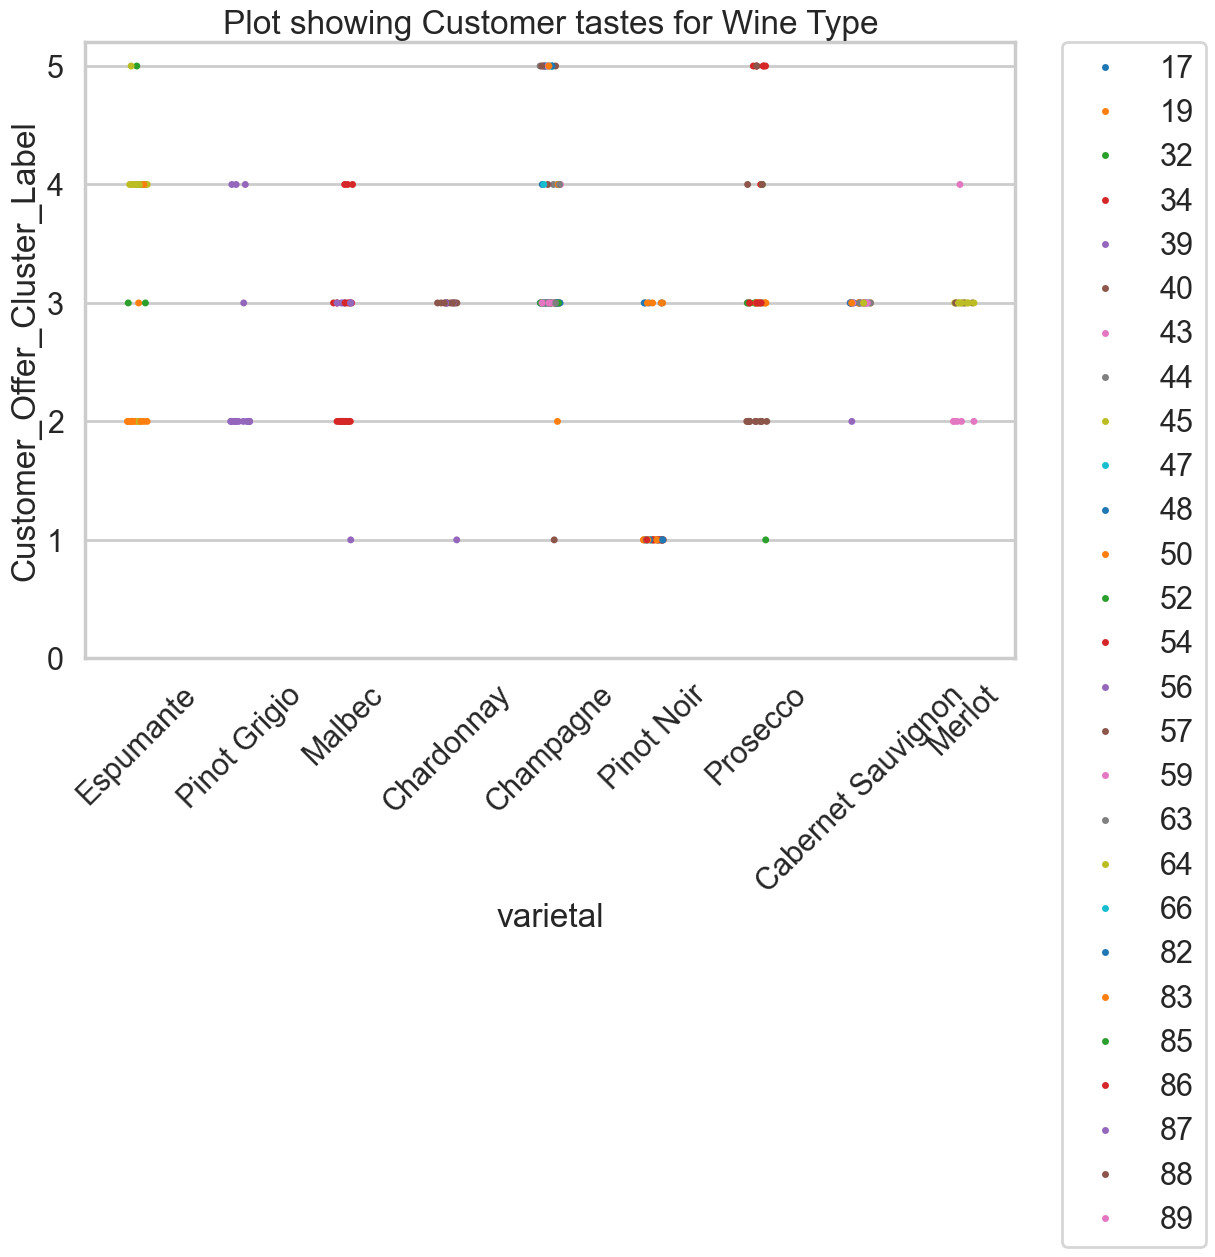

In [13]:
plt.figure(figsize=(12,8))
sns.stripplot(df_offers_transactions_labels,x='varietal',y='Customer_Offer_Cluster_Label',hue='discount',palette='tab10');
plt.xticks(rotation=45)
plt.yticks(np.arange(6))
# Position the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title('Plot showing Customer tastes for Wine Type')

<b> Recollect: The clusters consist of customers who selected certain offers, so customers with similar tastes are grouped into similar clusters </b>
<li> The tastes of customers seem pretty varied and flexible
<li> A certain class of customers preferred Pinot Noir only, suggesting they might have a taste for this wine
<li> Offering a 40% discount for Pinot Grigio seems like a good choice since many customers prefer this option
<li> In general, customers took up offers with 40-50% discount

#### 3aiii.  Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

#### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

**Hint:** See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

### 3b. Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

**Hint:** PCA was discussed in the previous subunit. If you need help with it, consult [this useful article](https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c) and [this visual explanation](http://setosa.io/ev/principal-component-analysis/). 

<b> When clustered with 5 clusters, we can see that it is difficult to spatially distinguish the clusters

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

<Axes: xlabel='x', ylabel='y'>

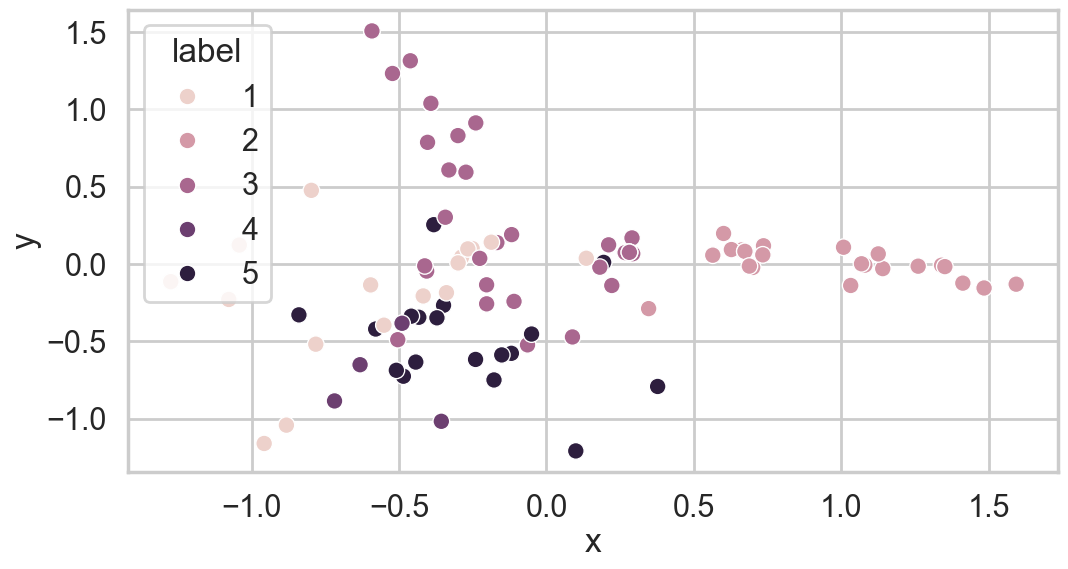

In [14]:
#your turn
from sklearn.decomposition import PCA
# Use K-means to cluster
model=KMeans(n_clusters=5)
labels=model.fit_predict(df_transactions_pivot[x_cols])+1
# PCA
x_pca=df_transactions_pivot[x_cols]
pca=PCA(n_components=2)
df_pca=pd.DataFrame(pca.fit_transform(x_pca),columns=['x','y'])
df_pca=pd.concat([df_transactions_pivot['customer_name'],df_pca],axis=1)
df_pca['label']=labels
# Plot Scatter
fig,axs=plt.subplots(1,1,figsize=(12,6))
sns.scatterplot(df_pca,x='x',y='y',hue='label')


What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

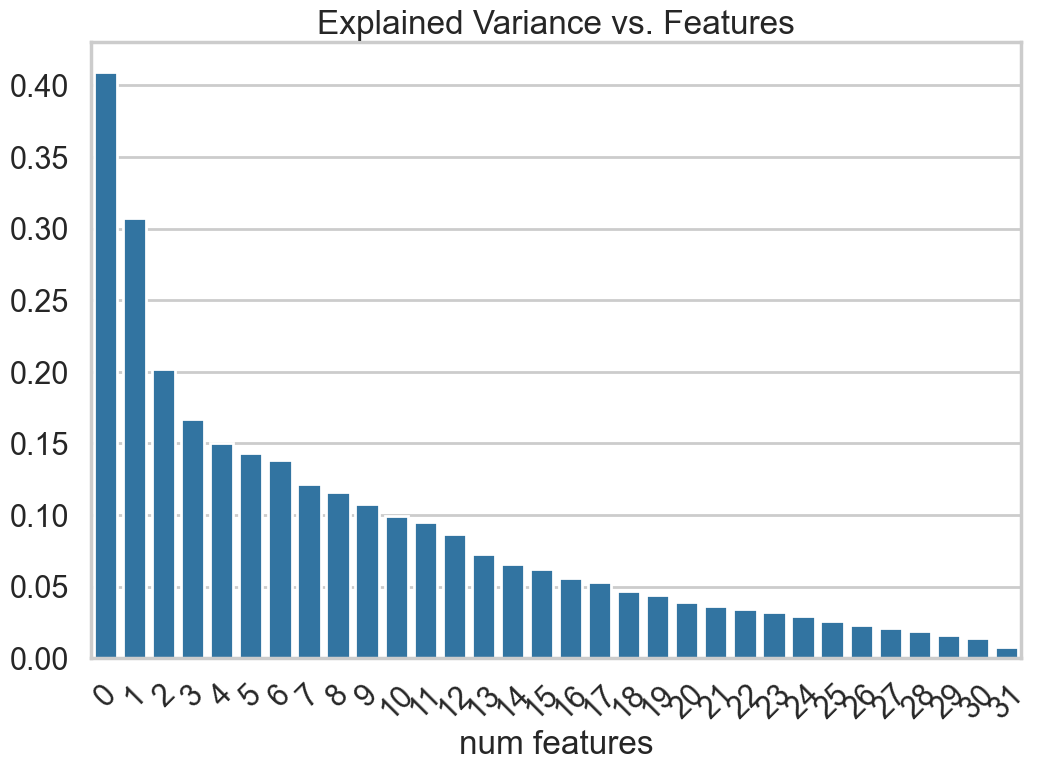

In [15]:
#your turn
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
X=df_transactions_pivot[x_cols]


# Do the rest on your own :)
pca.fit(X)

fig,axs=plt.subplots(1,1,figsize=(12,8))
sns.barplot(pca.explained_variance_)
axs.set_xlabel('num features')
plt.xticks(rotation=45)
plt.title('Explained Variance vs. Features')
plt.show()

<b>The slope becomes gradual around n=4

## 4. Conclusions and next steps
### 4a. Conclusions
What can you conclude from your investigations? Make a note, formulate it as clearly as possible, and be prepared to discuss it with your mentor in your next call. 

<p><b>
<li> There is lot of sparsity and variation in the dataset.
<li> This makes clustering difficult. Clusters plotted in a customer-offer space are evenly distributed in the space
<li> There is no 'perfect' n_clusters that will produce a good segmentation
<li> When we do a PCA with n_components=2 and plot the clusters, we can see greater entropy loss but not quite enough to provide good clusters
<li> Based on the explained variance plot, n_components=4 is probably a good value to obtain cluster labels against
</b></p>


### 4b. Other clustering algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


In [16]:
# Your turn
from sklearn.cluster import AffinityPropagation, SpectralClustering, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
import pandas as pd

def calculate_silhouette_scores(X,dbscan_eps):
    # List of clustering algorithms
    clustering_algorithms = [
        ("K-Means", KMeans(n_clusters=5)),
        ("Affinity Propagation", AffinityPropagation()),
        ("Spectral Clustering", SpectralClustering(n_clusters=5)),  
        ("Agglomerative Clustering", AgglomerativeClustering(n_clusters=5)),  
        ("DBSCAN", DBSCAN(eps=dbscan_eps))  
    ]
    
    # List to store the results
    results = []

    # Calculate silhouette scores for each algorithm
    for name, algorithm in clustering_algorithms:
        labels = algorithm.fit_predict(X)
        # Only calculate silhouette score if more than 1 cluster is formed
        if len(set(labels)) > 1:
            score = silhouette_score(X, labels)
        else:
            score = -1  # Invalid score if only one cluster is formed
        results.append((name, score))

    # Convert to a DataFrame
    df_scores = pd.DataFrame(results, columns=["Algorithm", "Silhouette Score"])
    return df_scores


In [17]:
df_clustering_comp_scores=calculate_silhouette_scores(df_transactions_pivot[x_cols],.5).sort_values(by='Silhouette Score',ascending=False).set_index("Algorithm")
df_clustering_comp_scores

,Silhouette Score
Algorithm,
Agglomerative Clustering,0.140897
K-Means,0.133971
Affinity Propagation,0.125199
Spectral Clustering,0.104250
DBSCAN,-1.000000


(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'Agglomerative Clustering'),
  Text(1, 0, 'K-Means'),
  Text(2, 0, 'Affinity Propagation'),
  Text(3, 0, 'Spectral Clustering'),
  Text(4, 0, 'DBSCAN')])

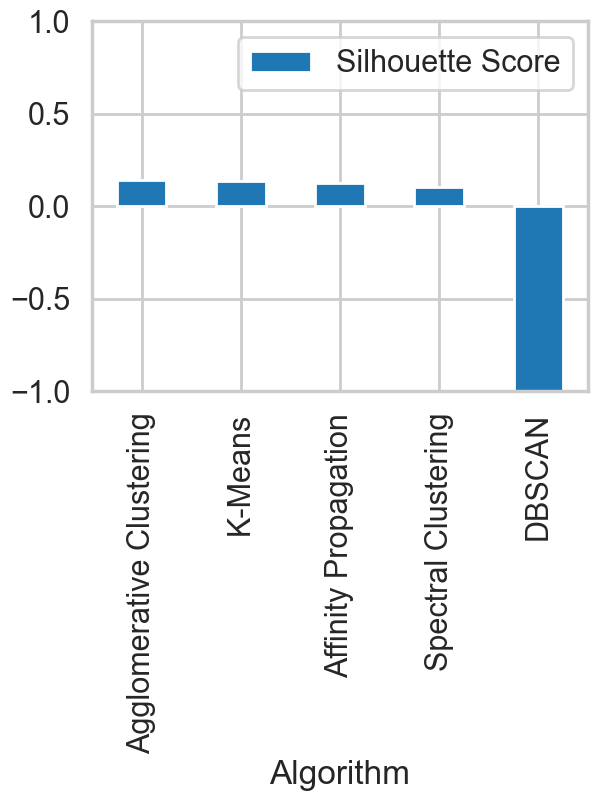

In [18]:
df_clustering_comp_scores.plot(kind='bar');
plt.ylim([-1,1])
plt.xticks(rotation=90)

Now increase epsilon for DBSCAN to 2

In [19]:
df_clustering_comp_scores=calculate_silhouette_scores(df_transactions_pivot[x_cols],2).sort_values(
    by='Silhouette Score',ascending=False).set_index("Algorithm")
df_clustering_comp_scores

,Silhouette Score
Algorithm,
DBSCAN,0.234890
Agglomerative Clustering,0.140897
Affinity Propagation,0.123082
K-Means,0.116373
Spectral Clustering,0.099157


(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'DBSCAN'),
  Text(1, 0, 'Agglomerative Clustering'),
  Text(2, 0, 'Affinity Propagation'),
  Text(3, 0, 'K-Means'),
  Text(4, 0, 'Spectral Clustering')])

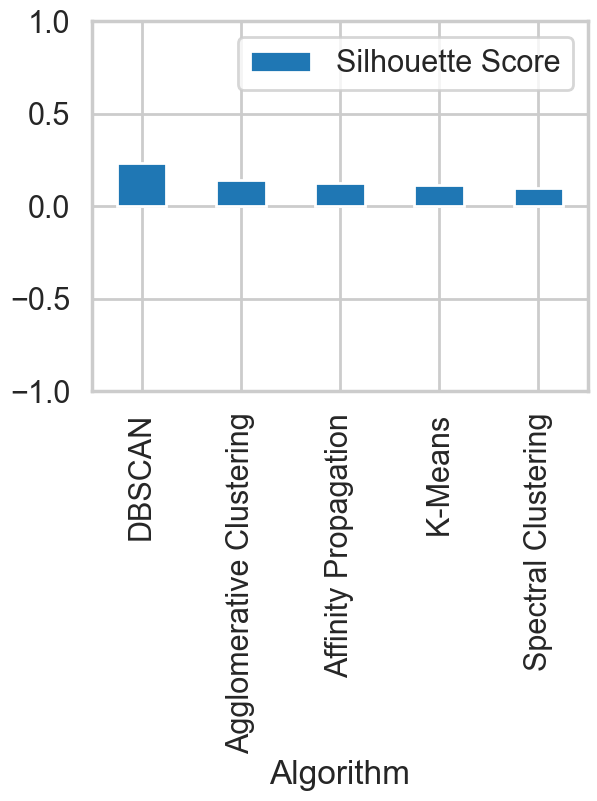

In [20]:
df_clustering_comp_scores.plot(kind='bar');
plt.ylim([-1,1])
plt.xticks(rotation=90)

<p><b>
<li> Initially, Agglomorative Clustering gives better silhoutte score than others even when the number of clusters is restricted to that of K-means. 
<li> Agglomorative Clustering performs bottom up hierarchical clustering by minimizing intra-cluster distance which would give a good Silhouette score
<li> DBScan initially performs the worst in this situation. The default epsilon=.5 considers almost all points as noise 
<li> When epsilon for DBSCAN is increased to 2, it outperforms all other algorithms. Increasing it to 3 again gets the score to -1 because there is only one cluster so inter cluster distance=0
</b></p>

## Cluster with DBSCAN epsilon=2

<Axes: xlabel='offer_id', ylabel='customer_name'>

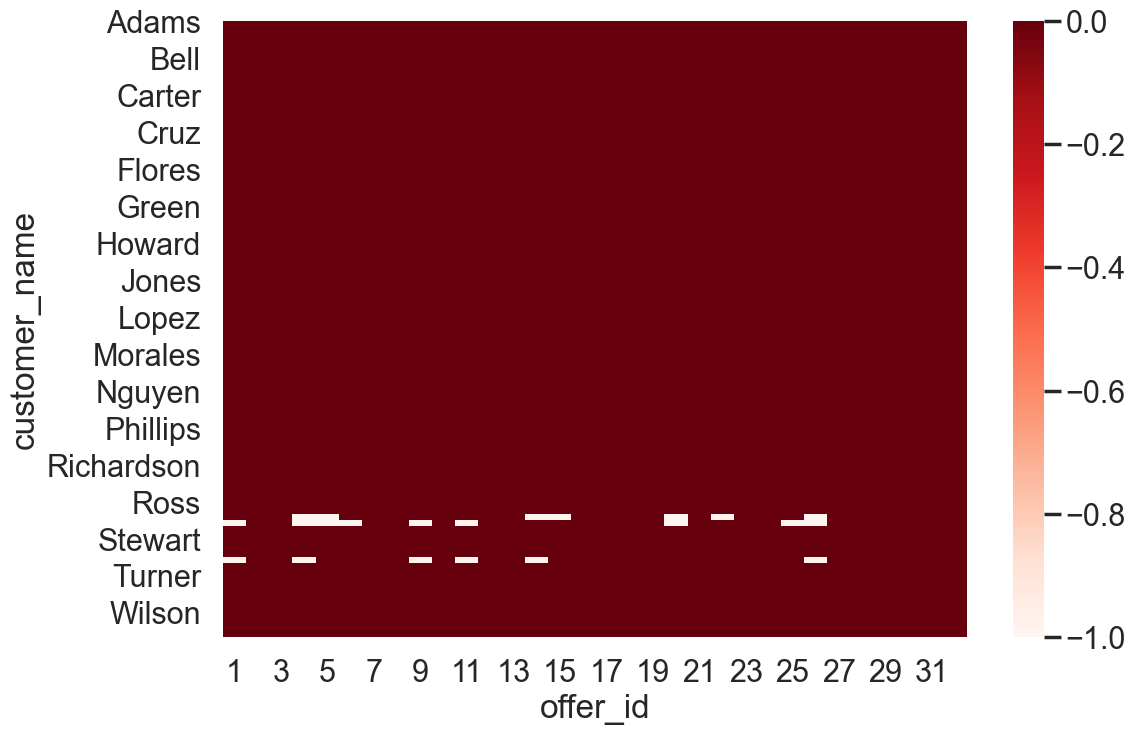

In [21]:
# Create cluster labels with dbscan eps=2
model= DBSCAN(eps=2)
labels=model.fit_predict(df_transactions_pivot[x_cols])
# Plot the points on X,Y
df_transactions_pivot['label']=labels

X=df_transactions_pivot.set_index('customer_name')
X[x_cols]=X[x_cols].values*X['label'].values.reshape(-1,1)
X=X.drop(columns='label')

fig,axs=plt.subplots(1,1,figsize=(12,8))
sns.heatmap(data=X,cmap='Reds')

In [22]:
df_offers_transactions_labels=pd.merge(df_offers_transactions,df_transactions_pivot[['customer_name','label']],on='customer_name',how='right').rename(
    columns={'label':'Customer_Offer_Cluster_Label'})
df_offers_transactions_labels

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak,customer_name,n,Customer_Offer_Cluster_Label
0,18,July,Espumante,6,50,Oregon,False,Adams,1,0
1,29,November,Pinot Grigio,6,87,France,False,Adams,1,0
2,30,December,Malbec,6,54,France,False,Adams,1,0
3,9,April,Chardonnay,144,57,Chile,False,Allen,1,0
4,27,October,Champagne,72,88,New Zealand,False,Allen,1,0
...,...,...,...,...,...,...,...,...,...,...
319,9,April,Chardonnay,144,57,Chile,False,Young,1,0
320,15,June,Cabernet Sauvignon,144,19,Italy,False,Young,1,0
321,22,August,Champagne,72,63,France,False,Young,1,0
322,31,December,Champagne,72,89,France,False,Young,1,0


Text(0.5, 1.0, 'Plot showing Customer tastes for Wine Type')

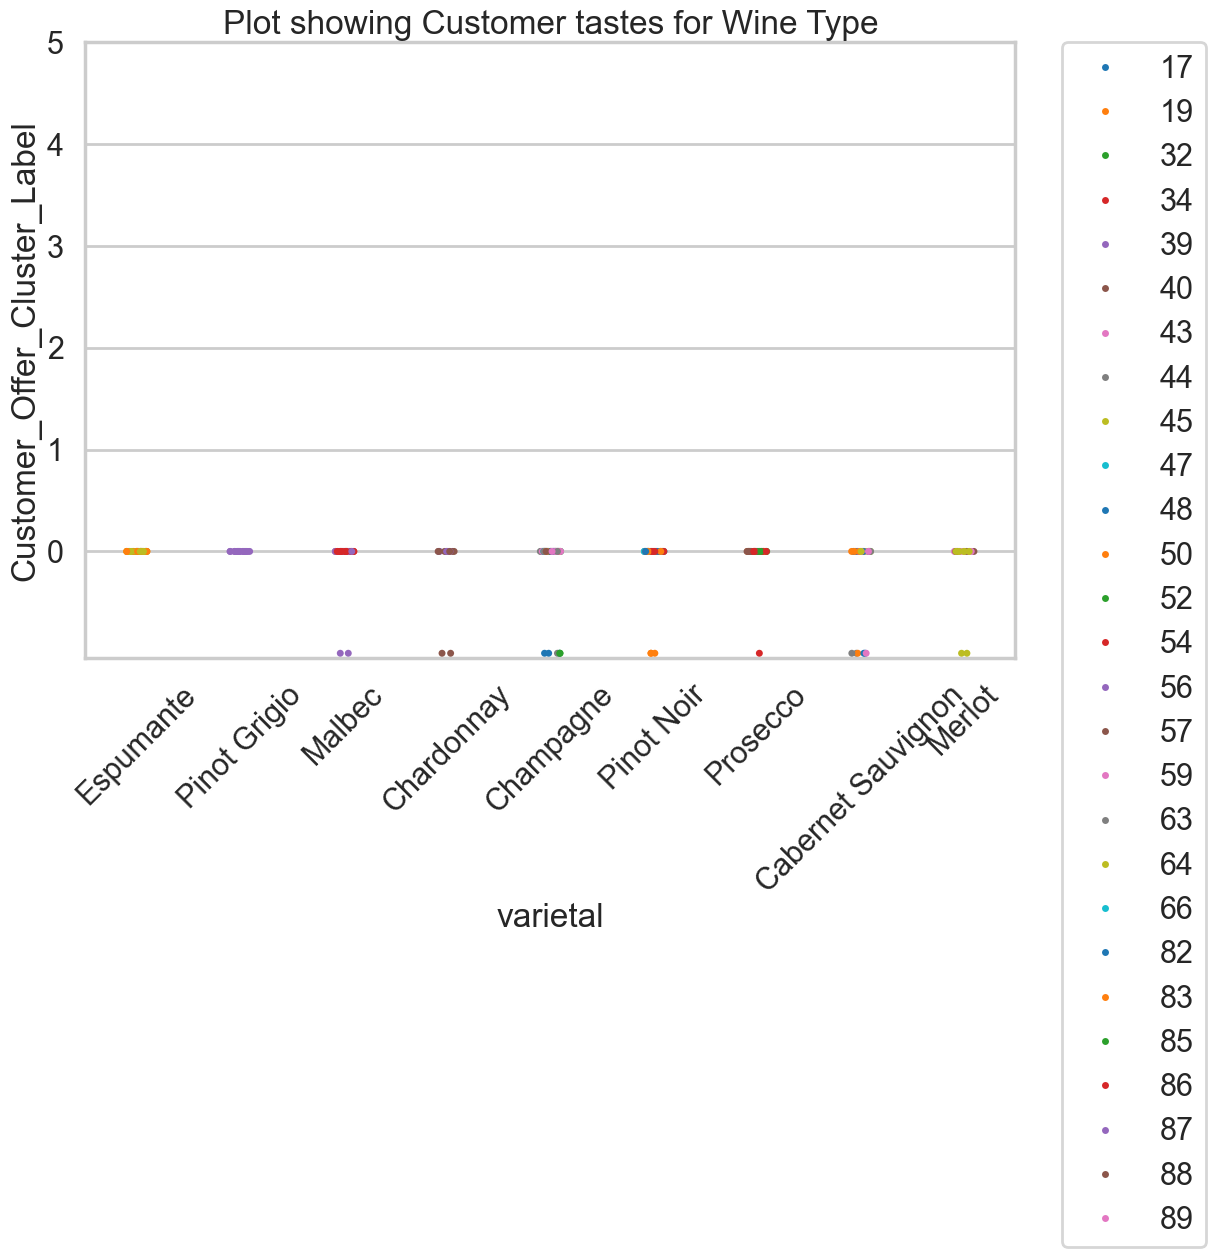

In [23]:
plt.figure(figsize=(12,8))
sns.stripplot(df_offers_transactions_labels,x='varietal',y='Customer_Offer_Cluster_Label',hue='discount',palette='tab10');
plt.xticks(rotation=45)
plt.yticks(np.arange(6))
# Position the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title('Plot showing Customer tastes for Wine Type')

<b>
<li> Re-running with DBSCAN eps=2 we get two classes: -1 and 1. -1 indicates outliers, so it seems most wine tasters are being clustered into one group
<li> This is consistent with what we've seen earlier
<li> Including other dimensions or features might help with this problem
</b>